# Perf stat analysis

In [10]:
import matplotlib.pyplot as plt
from typing import Optional, List, Tuple, Dict
import pandas as pd
import os
import re
import json
import subprocess
import numpy as np
from scipy import stats
from collections import defaultdict
import seaborn as sns

#### Global variables

In [11]:
TRACE_CMD_CACHE_FILENAME = "trace_cmd_runtimes"
RESULTS_DIR_PATH = "../results"
ABSOLUTE_RESULTS_DIR_PATH = "/home/cgachod/analysis/results"

PERF_STAT_RESULTS_EXTENSION = ".txt"

def get_result_dir_path(result_dir_name):
    return os.path.join(RESULTS_DIR_PATH, result_dir_name)

def in_result_dir(path: str):
    return os.path.join(RESULTS_DIR_PATH, path)

def get_absolute_result_dir_path(result_dir_name) :
    return os.path.join(ABSOLUTE_RESULTS_DIR_PATH, result_dir_name)

#### Visualization params

In [12]:
nb_enabled_color = "tab:orange"
nb_disabled_color = "tab:blue"

figure_height = 10 # 10
min_figure_width = 40
figure_width_coeff = 0.3

line_width = 1.0

In [13]:
def init_runs_plot():
    # plt.figure(figsize=(fig_width, 5))
    # plt.legend(loc="upper left")
    plt.xlabel("Nth run")
    plt.ylabel("Run time (seconds)")
    plt.grid(axis="y", which="both")
    plt.grid(axis="x", which="major")
    
    # ax = plt.gca()
    # ax.ticklabel_format(axis="x", useOffset=1.0)

def plot_runs(values: List[float], label = None, color = None, init_plot = True) :
    if init_plot:
        init_runs_plot()
    plt.plot(range(len(values)), values, label=label, color=color, linewidth=line_width)
    
    current_xticks_count = len(plt.xticks()[0])
    if len(values) > current_xticks_count :
        plt.xticks(range(len(values)), rotation=45)
        plt.xlim(-1, len(values))
        
    # candidate_ylim_max = max(values) * 1.2
    # if candidate_ylim_max > plt.ylim()[1] :
    #     plt.ylim(0, candidate_ylim_max)
        
    fig = plt.gcf()
    candidate_width = max(int(len(values) * figure_width_coeff), min_figure_width)
    curr_width = fig.get_size_inches()[0]
    if candidate_width > curr_width :
        fig.set_size_inches(candidate_width, figure_height)
    
    if label :
        plt.legend(loc="upper left")

In [14]:
def parse_per_cpu_result_file(file_path) -> Tuple[pd.DataFrame, Dict]:
    with open(file_path, 'r') as file:
        text = file.read()
    nas_time_match = re.search(r'Time in seconds\s+=\s+(\d*.\d*)', text)
    if nas_time_match :
        nas_time = float(nas_time_match.group(1))
        
    json_begin_pos = text.find('{')
    json_end_pos = text.rfind('}')
    json_text = text[json_begin_pos:json_end_pos + 1]
    json_lines = json_text.split('\n')
    
    events_df = pd.DataFrame()
    
    meta_values = {"nas_runtime": nas_time}
    
    event_counters: Dict[str, list] = defaultdict(list)
    for line in json_lines :
        json_object = json.loads(line)
        event_str = json_object["event"].strip()
        if event_str in ["duration_time", "user_time", "system_time"] :
            meta_values[event_str] = float(json_object["counter-value"])
        else :
            event_counters[event_str].append((int(json_object["cpu"]), float(json_object["counter-value"])))
    
    events_df = pd.DataFrame({event: [e[1] for e in sorted(values)] for event, values in event_counters.items()})
    if "LLC-load-misses" in events_df and "LLC-store-misses" in events_df and "LLC-loads" in events_df and "LLC-stores" in events_df:
        events_df["LLC-all-misses"] = events_df["LLC-load-misses"] + events_df["LLC-store-misses"]
        events_df["LLC-load-misses-ratio"] = events_df["LLC-load-misses"] / events_df["LLC-loads"]
        events_df["LLC-store-misses-ratio"] = events_df["LLC-store-misses"] / events_df["LLC-stores"]
    
    events_df["mem_load_l3_miss_retired.all"] = events_df["mem_load_l3_miss_retired.remote_dram"] + events_df["mem_load_l3_miss_retired.local_dram"]
    # events_df["mem_load_l3_miss_retired-over-LLC-all"] = events_df["mem_load_l3_miss_retired.all"] / events_df["LLC-all-misses"]
    events_df["mem_load_l3_miss_retired.remote_over_local_dram"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["mem_load_l3_miss_retired.local_dram"]
    events_df["mem_load_l3_miss_retired.remote_over_total"] = events_df["mem_load_l3_miss_retired.remote_dram"] / events_df["mem_load_l3_miss_retired.all"]
    events_df["mem_load_l3_miss_retired.local_over_total"] = events_df["mem_load_l3_miss_retired.local_dram"] / events_df["mem_load_l3_miss_retired.all"]
    
    return events_df, meta_values
    
    
# def parse_batch_results_event(dir_path, event) :
#     df = pd.DataFrame()
#     file_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if file.endswith(PERF_STAT_RESULTS_EXTENSION)]
#     for file_path in file_paths :
#         events_df, result_dict = parse_per_cpu_result_file(file_path)
#         series = events_df[event]
#         result_dict[f"min:{event}"] = series.min()
#         result_dict[f"max:{event}"] = series.max()
#         result_dict[f"sum:{event}"] = series.sum()
#         file_df = pd.DataFrame(result_dict, index=[0])
#         df = pd.concat([df, file_df], ignore_index=True)
#     return df


# Series is gonna conflict with pandas series
# Run / warmup : 1 execution of the program

def aggregate_run(file_path):
    pass


# TODO Add posibility to specify events
# parse_batch_results
# parse_batch_results
def parse_batch_results(dir_path) :
    file_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if file.endswith(PERF_STAT_RESULTS_EXTENSION)]
    concatenated_dict = defaultdict(list)
    for file_path in file_paths :
        events_df, meta_values = parse_per_cpu_result_file(file_path)
        for series_name, series in events_df.items() :
            concatenated_dict[f"min:{series_name}"].append(series.min())
            concatenated_dict[f"max:{series_name}"].append(series.max())
            concatenated_dict[f"sum:{series_name}"].append(series.sum())
            # concatenated_dict[f"avg:{series_name}"].append(series.sum() / len(series))
        for key, val in meta_values.items() :
            concatenated_dict[key].append(val)
    return pd.DataFrame(concatenated_dict)



# parse_batches_results_from_benchmark
# parse_batch from benchmark
# parse_series_independently ?
# Returns one dataframe for each series present in the directory
def parse_batches_results_from_benchmark(benchmark_dir_path: str) -> List[pd.DataFrame] :
    dfs = {}
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        print(f"Parsing batch in directory {dir_path}")
        dfs[c] = parse_batch_results(dir_path)
    return dfs


def combine_benchmark_dir(benchmark_dir_name) :
    df = pd.DataFrame()
    benchmark_dir_path = get_result_dir_path("_perf/" + benchmark_dir_name)
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        df = pd.concat([df, parse_batch_results(dir_path)], ignore_index=True)
    return df


In [22]:
events_df, meta_values = parse_per_cpu_result_file(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-disabled-sequential/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19__nb-disabled-sequential__perf_stat__99.txt"))

In [36]:
meta_values

{'nas_runtime': 9.76}

In [38]:
all_dfs = parse_batches_results_from_benchmark("cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10")

In [32]:
all_dfs["nb-disabled-sequential"]["avg:mem_load_l3_miss_retired.remote_over_total"]

0      0.241779
1      0.212494
2      0.252162
3      0.205279
4      0.180589
         ...   
295    0.245459
296    0.190320
297    0.247723
298    0.181654
299    0.187893
Name: avg:mem_load_l3_miss_retired.remote_over_total, Length: 300, dtype: float64

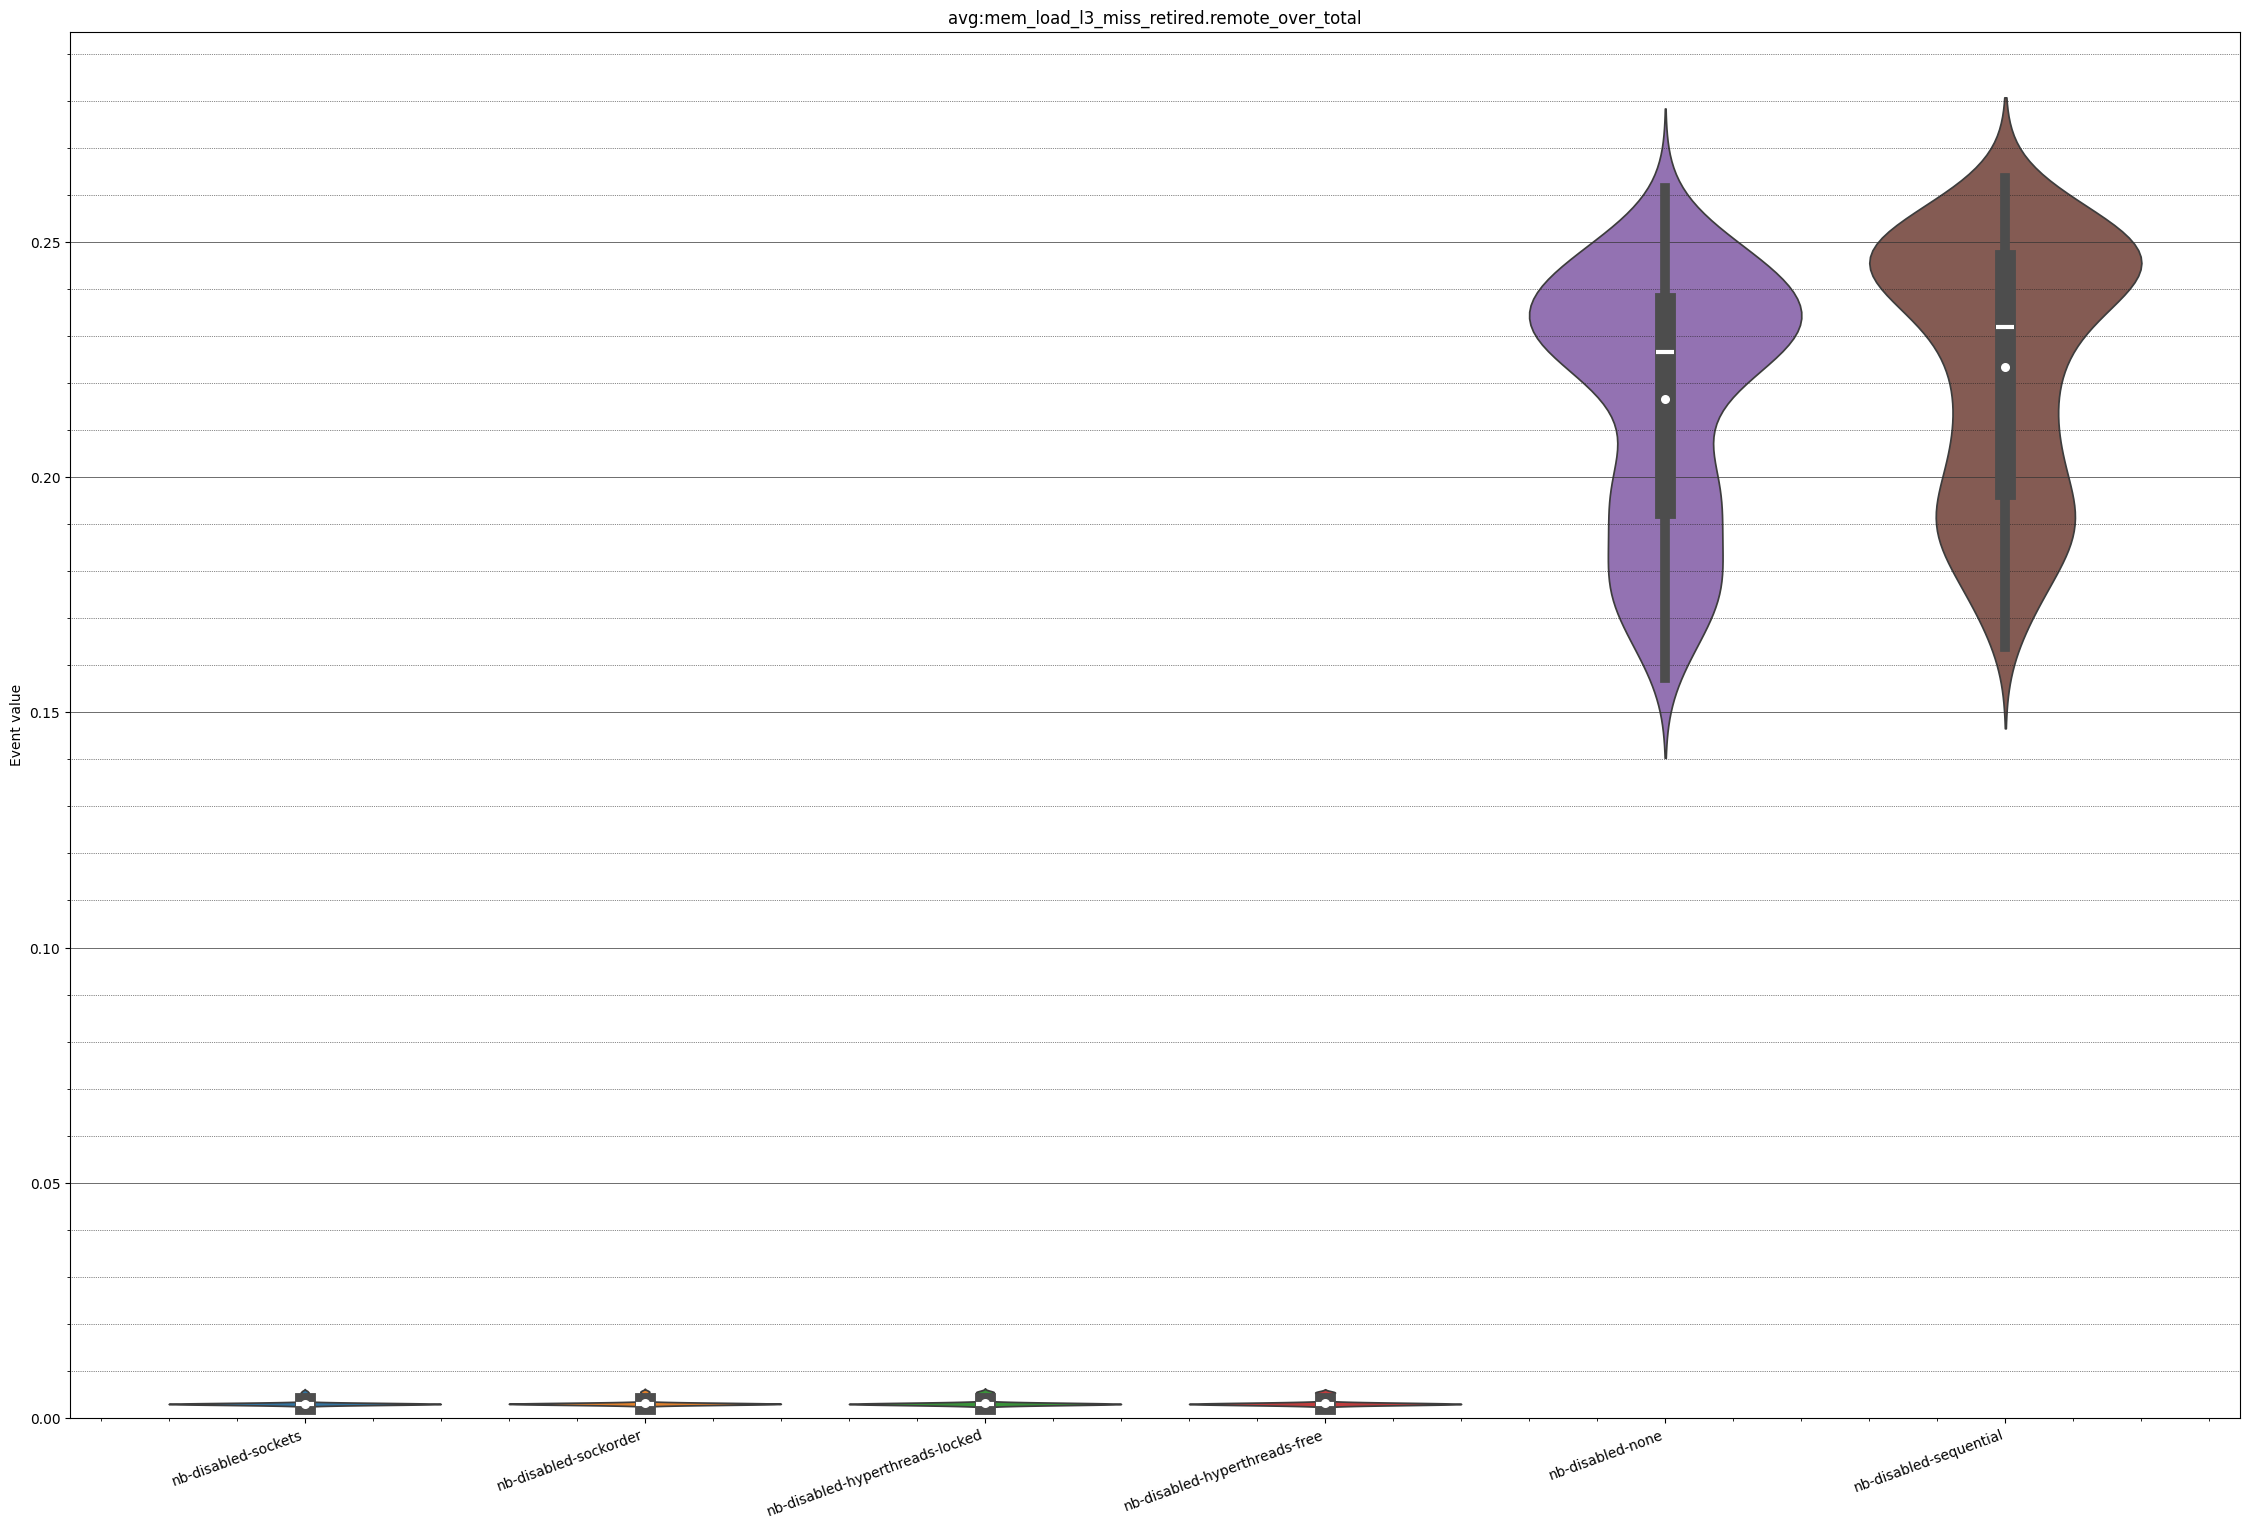

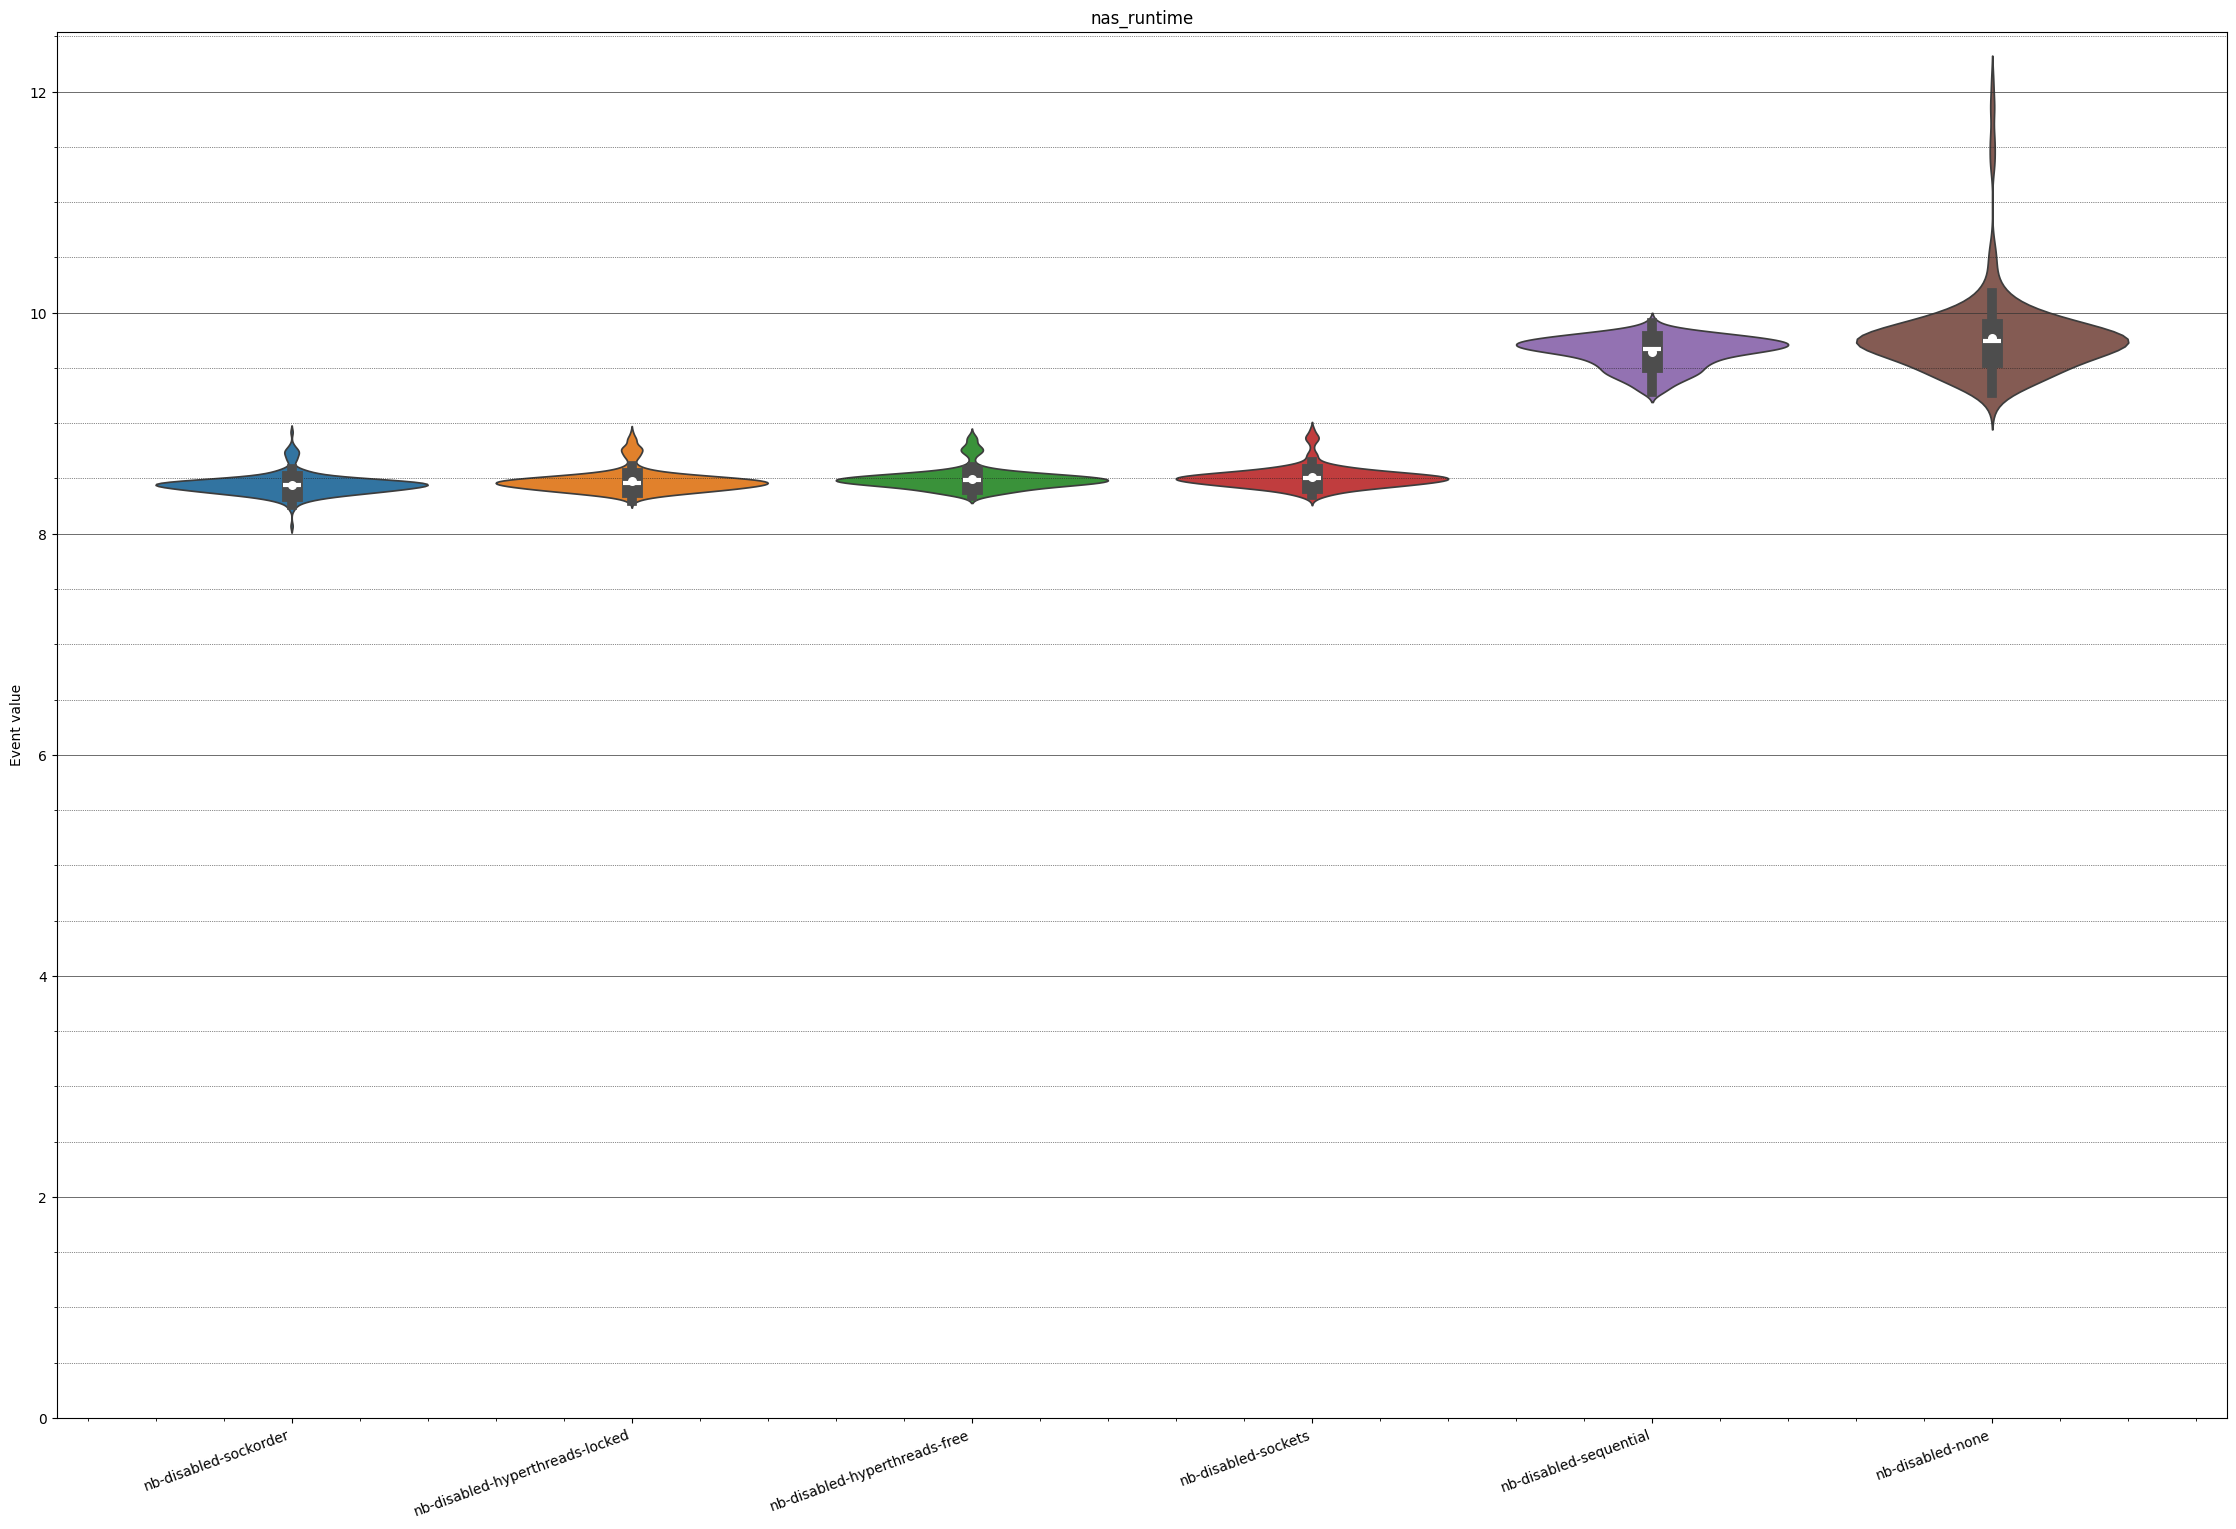

Index(['min:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd',
       'max:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd',
       'sum:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd',
       'avg:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd',
       'min:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd',
       'max:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd',
       'sum:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd',
       'avg:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd',
       'min:mem_load_l3_miss_retired.local_dram',
       'max:mem_load_l3_miss_retired.local_dram',
       ...
       'sum:mem_load_l3_miss_retired.remote_over_total',
       'avg:mem_load_l3_miss_retired.remote_over_total',
       'min:mem_load_l3_miss_retired.local_over_total',
       'max:mem_load_l3_miss_retired.local_over_tot

In [118]:
def plot_event_from_benchmark(all_dfs: Dict[str, pd.DataFrame], aggregated_event: str, variations_only = False) :
    plotting_df = pd.DataFrame({dir: df[aggregated_event] for dir, df in all_dfs.items()})
    means = plotting_df.mean().sort_values()
    sorted_plotting_df = plotting_df[means.index]
    
    if variations_only :
        reference_value = min(means)
        for col in sorted_plotting_df :
            sorted_plotting_df[col] = ((sorted_plotting_df[col] - reference_value) * 100) / reference_value
            
    plt.ylabel("Event value")
    sns.violinplot(data = sorted_plotting_df, inner_kws=dict(box_width=15, whis_width=7, color=".3"))

    plt.gcf().set_size_inches(28, 18)
    plt.xticks(rotation=20, ha='right')
    plt.minorticks_on()
    plt.grid(axis="y", which="major", color='0.2', linestyle='-', linewidth=0.5)
    plt.grid(axis="y", which="minor", color='0.1', linestyle=':', linewidth=0.5)
    plt.scatter(x=range(len(means)),y=means, marker='o', s=30, c="white", alpha=1, zorder=10)
    # plt.grid(axis="x", which="major")
    plt.ylim(bottom=0.0)
    plt.title(aggregated_event)
    plt.show()
    

In [1]:
plot_event_from_benchmark(all_dfs, "avg:mem_load_l3_miss_retired.remote_over_total")
plot_event_from_benchmark(all_dfs, "nas_runtime")

list(all_dfs.values())[0].columns

NameError: name 'plot_event_from_benchmark' is not defined

In [ ]:
# What we want is :
# - A boxplot for each folder, sorted by increasing values with mean being 0
# - Another boxplot showing times ?
# - Fow now only work on aggregated values


def extract_event_from_dir(dir_path, event) -> Tuple[List[pd.DataFrame], Dict[list]] :
    events_dfs = []
    metas = defaultdict(list)
    file_paths = [os.path.join(dir_path, file) for file in os.listdir(dir_path) if file.endswith(PERF_STAT_RESULTS_EXTENSION)]
    for file_path in file_paths :
        file_df, file_meta = parse_per_cpu_result_file(file_path)
        events_dfs.append(file_df[event])
        
        for key, val in file_meta.items() :
            metas[key].append(val)
    return events_dfs, metas

def boxplot_event_for_benchmark_dir(benchmark_dir_name, event, aggregation_fun) :
    benchmark_dir_path = get_result_dir_path("_perf/" + benchmark_dir_name)
    
    dir_events_dfs = []
    dir_metas_dfs = []
    contents = os.listdir(benchmark_dir_path)
    for c in contents :
        dir_path = os.path.join(benchmark_dir_path, c)
        if not os.path.isdir(dir_path) :
            continue
        
        events_dfs, metas = extract_event_from_dir(dir_path, event)
        agg_df = pd.concat(events_dfs, ignore_index=True)
        metas_df = pd.DataFrame(metas)
        
    all_event_data
    plt.violinplot()

In [11]:
parse_batch_results_event(
    get_result_dir_path("_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-sockets"), 
    "mem_load_l3_miss_retired.remote_over_total"
)

,nas_runtime,duration_time,user_time,system_time,min:mem_load_l3_miss_retired.remote_over_total,max:mem_load_l3_miss_retired.remote_over_total,sum:mem_load_l3_miss_retired.remote_over_total
0,8.58,9.074043e+09,5.842017e+11,9.196750e+08,0.000038,0.136917,0.181004
1,8.52,9.010594e+09,5.796735e+11,1.423541e+09,0.000006,0.095542,0.179664
2,8.42,8.908582e+09,5.727715e+11,1.143647e+09,0.000017,0.138969,0.181495
3,8.43,8.922408e+09,5.743905e+11,8.796790e+08,0.000009,0.106757,0.197062
4,8.85,9.336142e+09,6.006647e+11,1.215661e+09,0.000017,0.290028,0.358125
...,...,...,...,...,...,...,...
295,8.52,9.005226e+09,5.799552e+11,1.007811e+09,0.000034,0.102013,0.191967
296,8.37,8.859970e+09,5.703969e+11,1.223512e+09,0.000006,0.112420,0.198122
297,8.43,8.925100e+09,5.737476e+11,1.327841e+09,0.000010,0.115895,0.198429
298,8.57,9.063683e+09,5.835700e+11,7.559450e+08,0.000006,0.104531,0.186115


In [7]:
# Idea is to boxplot all the values for all the cores for each run

df, meta = parse_per_cpu_result_file(get_result_dir_path("_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-sockets/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10__nb-disabled-sockets__99.txt"))
df

,offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd,offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd,mem_load_l3_miss_retired.local_dram,mem_load_l3_miss_retired.remote_dram,branches,branch-misses,l2_rqsts.all_demand_references,l2_rqsts.all_demand_miss,l2_rqsts.all_demand_data_rd,l2_rqsts.demand_data_rd_miss,...,migrations,context-switches,LLC-all-misses,LLC-load-misses-ratio,LLC-store-misses-ratio,mem_load_l3_miss_retired.all,mem_load_l3_miss_retired-over-LLC-all,mem_load_l3_miss_retired.remote_over_local_dram,mem_load_l3_miss_retired.remote_over_total,mem_load_l3_miss_retired.local_over_total
0,0.0,88246.0,46989277.0,2422.0,1.527217e+09,8984180.0,1.159246e+09,416091139.0,1.155941e+09,415978702.0,...,2.0,66.0,49181492.0,0.117389,0.345564,46991699.0,0.955475,0.000052,0.000052,0.999948
1,0.0,26310.0,46879400.0,30823.0,1.526366e+09,9707927.0,1.145700e+09,410878331.0,1.142663e+09,410602999.0,...,1.0,49.0,48908153.0,0.118128,0.374482,46910223.0,0.959149,0.000657,0.000657,0.999343
2,0.0,97785.0,47737946.0,2701.0,1.514201e+09,9983559.0,1.151877e+09,414133963.0,1.149073e+09,413538309.0,...,1.0,39.0,49949974.0,0.119913,0.357720,47740647.0,0.955769,0.000057,0.000057,0.999943
3,0.0,20644.0,46026968.0,26437.0,1.528751e+09,9651958.0,1.152499e+09,414068171.0,1.149218e+09,413572550.0,...,1.0,31.0,48053561.0,0.115246,0.354873,46053405.0,0.958377,0.000574,0.000574,0.999426
4,0.0,109878.0,47579571.0,1807.0,1.514852e+09,10036098.0,1.155456e+09,414578498.0,1.152457e+09,415025433.0,...,2.0,26.0,49793996.0,0.119021,0.398331,47581378.0,0.955565,0.000038,0.000038,0.999962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.0,21714.0,48649320.0,25254.0,1.542815e+09,7677849.0,1.156208e+09,413137721.0,1.149292e+09,411216750.0,...,1.0,112.0,50382184.0,0.121109,0.639233,48674574.0,0.966107,0.000519,0.000519,0.999481
60,0.0,111555.0,46997113.0,2481.0,1.534369e+09,7251561.0,1.154648e+09,412037355.0,1.147774e+09,410068963.0,...,1.0,24.0,48898370.0,0.117767,0.678408,46999594.0,0.961169,0.000053,0.000053,0.999947
61,0.0,13158.0,45863396.0,17861.0,1.534749e+09,7607473.0,1.150297e+09,410753365.0,1.142610e+09,408463753.0,...,1.0,26.0,47554272.0,0.115116,0.594839,45881257.0,0.964819,0.000389,0.000389,0.999611
62,0.0,109222.0,46653400.0,1801.0,1.542116e+09,7345155.0,1.154160e+09,411681446.0,1.147628e+09,409837280.0,...,2.0,56.0,48662597.0,0.117310,0.679021,46655201.0,0.958749,0.000039,0.000039,0.999961


In [7]:
dfs = parse_batches_results_from_benchmark("cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10")

In [ ]:
dfs.keys()

In [37]:
events_df, meta_values = parse_per_cpu_result_file(get_result_dir_path("_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10-sample/nb-disabled-sockorder/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10__nb-disabled-sockorder__1.txt"))

for col in events_df.columns :
    print(col, sum(events_df[col]))

offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd 0.0
offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd 1475086.0
mem_load_l3_miss_retired.local_dram 2930651867.0
mem_load_l3_miss_retired.remote_dram 8072208.0
branches 98524560882.0
branch-misses 619990895.0
l2_rqsts.all_demand_references 73429495859.0
l2_rqsts.all_demand_miss 26855954244.0
l2_rqsts.all_demand_data_rd 73221738189.0
l2_rqsts.demand_data_rd_miss 26801344423.0
LLC-loads 26856996677.0
LLC-load-misses 3040067133.0
LLC-stores 53587612.0
LLC-store-misses 23493904.0
cycle_activity.stalls_l3_miss 515847787046.0
cache-references 37544134258.0
cache-misses 12662244550.0
cycles 1499838949723.0
instructions 665634513265.0
migrations 79.0
context-switches 2195.0
LLC-all-misses 3063561037.0
LLC-load-misses-ratio 7.244273564662786
LLC-store-misses-ratio 28.02543178583359
mem_load_l3_miss_retired.all 2938724075.0
mem_load_l3_miss_retired-over-LLC-all 61.39187966516469
mem_load_l3_miss_retired.remo

In [39]:
perf_df = combine_benchmark_dir("cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10")

In [40]:
perf_df

,nas_runtime,duration_time,user_time,system_time,min:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd,max:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd,sum:offcore_response.all_data_rd.l3_miss_local_dram.snoop_miss_or_no_fwd,min:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd,max:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd,sum:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd,...,sum:mem_load_l3_miss_retired-over-LLC-all,min:mem_load_l3_miss_retired.remote_over_local_dram,max:mem_load_l3_miss_retired.remote_over_local_dram,sum:mem_load_l3_miss_retired.remote_over_local_dram,min:mem_load_l3_miss_retired.remote_over_total,max:mem_load_l3_miss_retired.remote_over_total,sum:mem_load_l3_miss_retired.remote_over_total,min:mem_load_l3_miss_retired.local_over_total,max:mem_load_l3_miss_retired.local_over_total,sum:mem_load_l3_miss_retired.local_over_total
0,8.52,9.010382e+09,5.804162e+11,6.197860e+08,0.0,0.0,0.0,1340.0,485757.0,2000298.0,...,61.670529,0.000005,0.117910,0.210604,0.000005,0.105474,0.194110,0.894526,0.999995,63.805890
1,8.46,8.950090e+09,5.762515e+11,8.875430e+08,0.0,0.0,0.0,1064.0,412286.0,1999891.0,...,61.389508,0.000006,0.148544,0.200673,0.000006,0.129332,0.180758,0.870668,0.999994,63.819242
2,8.50,8.992876e+09,5.786182e+11,1.211510e+09,0.0,0.0,0.0,15281.0,300151.0,3355412.0,...,61.587630,0.000019,0.127258,0.216224,0.000019,0.112891,0.198025,0.887109,0.999981,63.801975
3,8.47,8.957064e+09,5.768636e+11,9.236020e+08,0.0,0.0,0.0,12620.0,460849.0,2661309.0,...,61.432032,0.000009,0.118275,0.207096,0.000009,0.105765,0.190309,0.894235,0.999991,63.809691
4,8.39,8.881550e+09,5.719484e+11,8.799690e+08,0.0,0.0,0.0,956.0,275619.0,1990983.0,...,61.430011,0.000005,0.118361,0.217567,0.000005,0.105834,0.199486,0.894166,0.999995,63.800514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,8.52,9.005226e+09,5.799552e+11,1.007811e+09,0.0,0.0,0.0,17695.0,595193.0,11651510.0,...,61.747261,0.000034,0.113602,0.207225,0.000034,0.102013,0.191967,0.897987,0.999966,63.808033
1796,8.37,8.859970e+09,5.703969e+11,1.223512e+09,0.0,0.0,0.0,1242.0,555365.0,5420872.0,...,62.006998,0.000006,0.126659,0.216503,0.000006,0.112420,0.198122,0.887580,0.999994,63.801878
1797,8.43,8.925100e+09,5.737476e+11,1.327841e+09,0.0,0.0,0.0,1034.0,569668.0,2047288.0,...,61.931158,0.000010,0.131088,0.218226,0.000010,0.115895,0.198429,0.884105,0.999990,63.801571
1798,8.57,9.063683e+09,5.835700e+11,7.559450e+08,0.0,0.0,0.0,1187.0,521809.0,1641780.0,...,61.568475,0.000006,0.116734,0.202211,0.000006,0.104531,0.186115,0.895469,0.999994,63.813885


In [42]:
pd.set_option('display.max_rows', 500)
correlations = perf_df.corr()['nas_runtime']
# print(perf_df.corr()['once:nas_runtime'].sort_values())



# new_df = correlations.to_frame(name = "corr")
# new_df["abs_corr"] = new_df["corr"].map(lambda x : abs(x))
# new_df.sort_values(by = "abs_corr", ascending=False)

correlations.sort_values(ascending=False)

nas_runtime                                                                  1.000000
user_time                                                                    0.999876
duration_time                                                                0.999848
max:cycles                                                                   0.997377
sum:cycles                                                                   0.995174
min:cycles                                                                   0.963998
sum:mem_load_l3_miss_retired.remote_over_total                               0.958543
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.956608
sum:mem_load_l3_miss_retired.remote_dram                                     0.956308
max:mem_load_l3_miss_retired.remote_over_total                               0.941978
sum:offcore_response.all_data_rd.l3_miss_remote_dram.snoop_miss_or_no_fwd    0.939587
max:mem_load_l3_miss_retired.remote_dram              

In [ ]:
# TODO Print the box plots : one graph per event, on each graph 3 functions for all the setups

### Focus on L3 miss categories

In [ ]:
bench = read_perf_stat_benchmark_dir("_perf/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-03-17")
# bench.print_available_events()

# test_file_result_path = "cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-03-17/nb-disabled-none/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-03-17__nb-disabled-none__99.txt"
# result = parse_perf_stat_result_file(get_result_dir_path(test_file_result_path))
# # print(result.event_counters)

plot_perf_stat_benchmark_for_events(bench, events=events, sort_by_event="nas_runtime")


In [31]:
test_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19"))

Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-disabled-none
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-enabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-enabled-sockorder
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-disabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-disabled-sockorder
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-19/nb-enabled-none


In [35]:
len(test_dfs)

test_dfs.keys()

test_dfs['nb-disabled-sequential']

,min:mem_load_l3_miss_retired.local_dram,max:mem_load_l3_miss_retired.local_dram,sum:mem_load_l3_miss_retired.local_dram,avg:mem_load_l3_miss_retired.local_dram,min:mem_load_l3_miss_retired.remote_dram,max:mem_load_l3_miss_retired.remote_dram,sum:mem_load_l3_miss_retired.remote_dram,avg:mem_load_l3_miss_retired.remote_dram,min:mem_load_l3_miss_retired.remote_fwd,max:mem_load_l3_miss_retired.remote_fwd,...,avg:mem_load_l3_miss_retired.remote_over_local_dram,min:mem_load_l3_miss_retired.remote_over_total,max:mem_load_l3_miss_retired.remote_over_total,sum:mem_load_l3_miss_retired.remote_over_total,avg:mem_load_l3_miss_retired.remote_over_total,min:mem_load_l3_miss_retired.local_over_total,max:mem_load_l3_miss_retired.local_over_total,sum:mem_load_l3_miss_retired.local_over_total,avg:mem_load_l3_miss_retired.local_over_total,nas_runtime
0,24942496.0,49815050.0,2.458708e+09,3.841730e+07,2213.0,13309445.0,497845574.0,7.778837e+06,245844.0,538379.0,...,0.217337,0.000045,0.346951,10.946161,0.171034,0.653049,0.999955,53.053839,0.828966,9.23
1,25763282.0,48830743.0,2.377497e+09,3.714840e+07,2816.0,15146624.0,527622083.0,8.244095e+06,297640.0,518470.0,...,0.238435,0.000058,0.361971,11.734454,0.183351,0.638029,0.999942,52.265546,0.816649,9.38
2,21197166.0,45657606.0,1.987964e+09,3.106194e+07,5068.0,15818201.0,611154551.0,9.549290e+06,410938.0,540116.0,...,0.341578,0.000120,0.427341,15.328378,0.239506,0.572659,0.999880,48.671622,0.760494,9.64
3,23290390.0,49222966.0,2.203843e+09,3.443504e+07,3285.0,17370683.0,655218059.0,1.023778e+07,323434.0,529534.0,...,0.326679,0.000071,0.421464,14.864256,0.232254,0.578536,0.999929,49.135744,0.767746,9.54
4,23436237.0,49912423.0,2.214810e+09,3.460641e+07,25632.0,18138171.0,643429661.0,1.005359e+07,300230.0,499499.0,...,0.331445,0.000559,0.433297,14.739458,0.230304,0.566703,0.999441,49.260542,0.769696,9.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,21380947.0,48105675.0,2.058965e+09,3.217132e+07,3388.0,17624731.0,651418742.0,1.017842e+07,343192.0,483433.0,...,0.356287,0.000070,0.451850,15.727442,0.245741,0.548150,0.999930,48.272558,0.754259,9.64
196,28976601.0,49438955.0,2.386564e+09,3.729006e+07,6777.0,14624122.0,505617522.0,7.900274e+06,291573.0,523107.0,...,0.225227,0.000140,0.335410,11.334604,0.177103,0.664590,0.999860,52.665396,0.822897,9.28
197,22046939.0,45610956.0,2.031117e+09,3.173620e+07,4811.0,16808557.0,634529795.0,9.914528e+06,419612.0,549519.0,...,0.344076,0.000111,0.428658,15.459659,0.241557,0.571342,0.999889,48.540341,0.758443,9.62
198,23443397.0,43969722.0,2.055597e+09,3.211871e+07,6749.0,16353014.0,600322000.0,9.380031e+06,362904.0,500950.0,...,0.319805,0.000153,0.410917,14.664631,0.229135,0.589083,0.999847,49.335369,0.770865,9.53


In [8]:
def print_correlations(df: pd.DataFrame):
    pd.set_option('display.max_rows', 500)
    correlations = df.corr()['nas_runtime']
    # print(perf_df.corr()['once:nas_runtime'].sort_values())



    # new_df = correlations.to_frame(name = "corr")
    # new_df["abs_corr"] = new_df["corr"].map(lambda x : abs(x))
    # new_df.sort_values(by = "abs_corr", ascending=False)

    display(correlations.sort_values(ascending=False))
    
    
# First within each batch, and then as a whole



In [41]:
# for key, value in test_dfs.items():
#     print(f"Correlations for {key}")
#     print_correlations(value)
    
    
concatenated = pd.concat(test_dfs.values())
print_correlations(concatenated)

nas_runtime                                            1.000000
max:mem_load_l3_miss_retired.remote_over_total         0.451598
max:mem_load_l3_miss_retired.remote_over_local_dram    0.431343
avg:mem_load_l3_miss_retired.remote_over_local_dram    0.430947
sum:mem_load_l3_miss_retired.remote_over_local_dram    0.430947
sum:mem_load_l3_miss_retired.remote_over_total         0.423967
avg:mem_load_l3_miss_retired.remote_over_total         0.423967
max:mem_load_l3_miss_retired.remote_dram               0.398216
avg:mem_load_l3_miss_retired.remote_dram               0.332943
sum:mem_load_l3_miss_retired.remote_dram               0.332943
min:mem_load_l3_miss_retired.remote_hitm               0.262399
avg:mem_load_l3_miss_retired.remote_hitm               0.239086
sum:mem_load_l3_miss_retired.remote_hitm               0.239086
min:mem_load_l3_miss_retired.remote_fwd                0.201946
min:mem_load_l3_miss_retired.remote_over_total         0.133922
min:mem_load_l3_miss_retired.remote_over

In [47]:
reduced_concatenated = concatenated[["nas_runtime", "avg:mem_load_l3_miss_retired.remote_over_total", "sum:mem_load_l3_miss_retired.remote_over_total"]]
reduced_concatenated

,nas_runtime,avg:mem_load_l3_miss_retired.remote_over_total,sum:mem_load_l3_miss_retired.remote_over_total
0,8.52,0.003033,0.194110
1,8.46,0.002824,0.180758
2,8.50,0.003094,0.198025
3,8.47,0.002974,0.190309
4,8.39,0.003117,0.199486
...,...,...,...
295,8.52,0.002999,0.191967
296,8.37,0.003096,0.198122
297,8.43,0.003100,0.198429
298,8.57,0.002908,0.186115


In [48]:
print_correlations(reduced_concatenated)

nas_runtime                                       1.000000
avg:mem_load_l3_miss_retired.remote_over_total    0.958543
sum:mem_load_l3_miss_retired.remote_over_total    0.958543
Name: nas_runtime, dtype: float64

In [42]:
test_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10"))
concatenated = pd.concat(test_dfs.values())
print_correlations(concatenated)

Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-hyperthreads-locked
Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-hyperthreads-free
Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-none
Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-sequential
Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-sockorder
Parsing batch in directory ../results/_perf/cg.C.x__dahu-21__v6.8.0-rc3__performance__2024-04-10/nb-disabled-sockets


nas_runtime                                                                  1.000000
user_time                                                                    0.999876
duration_time                                                                0.999848
max:cycles                                                                   0.997377
sum:cycles                                                                   0.995174
avg:cycles                                                                   0.995174
min:cycles                                                                   0.963998
avg:mem_load_l3_miss_retired.remote_over_total                               0.958543
sum:mem_load_l3_miss_retired.remote_over_total                               0.958543
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.956608
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.956608
avg:mem_load_l3_miss_retired.remote_dram              

In [43]:
for key, value in test_dfs.items():
    print(f"Correlations for {key}")
    print_correlations(value)

Correlations for nb-disabled-hyperthreads-locked


nas_runtime                                                                  1.000000
duration_time                                                                0.999318
user_time                                                                    0.999120
max:cycles                                                                   0.980625
sum:cycles                                                                   0.945800
avg:cycles                                                                   0.945800
min:cycles                                                                   0.875508
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.801101
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.801101
avg:mem_load_l3_miss_retired.remote_over_total                               0.786878
sum:mem_load_l3_miss_retired.remote_over_total                               0.786878
max:mem_load_l3_miss_retired.remote_over_local_dram   

Correlations for nb-disabled-hyperthreads-free


nas_runtime                                                                  1.000000
duration_time                                                                0.999248
user_time                                                                    0.999007
max:cycles                                                                   0.980727
avg:cycles                                                                   0.954494
sum:cycles                                                                   0.954494
min:cycles                                                                   0.897866
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.772688
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.772688
avg:mem_load_l3_miss_retired.remote_over_total                               0.755689
sum:mem_load_l3_miss_retired.remote_over_total                               0.755689
max:mem_load_l3_miss_retired.remote_over_local_dram   

Correlations for nb-disabled-none


nas_runtime                                                                  1.000000
duration_time                                                                0.998868
user_time                                                                    0.998852
max:cycles                                                                   0.982190
sum:cycles                                                                   0.960024
avg:cycles                                                                   0.960024
sum:branches                                                                 0.903354
avg:branches                                                                 0.903354
sum:instructions                                                             0.887099
avg:instructions                                                             0.887099
max:context-switches                                                         0.724486
max:branches                                          

Correlations for nb-disabled-sequential


nas_runtime                                                                  1.000000
duration_time                                                                0.999569
user_time                                                                    0.999371
max:cycles                                                                   0.983840
avg:cycles                                                                   0.973776
sum:cycles                                                                   0.973776
min:cycles                                                                   0.960302
sum:mem_load_l3_miss_retired.remote_over_total                               0.799753
avg:mem_load_l3_miss_retired.remote_over_total                               0.799753
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.797939
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.797939
sum:mem_load_l3_miss_retired.remote_dram              

Correlations for nb-disabled-sockorder


nas_runtime                                                                  1.000000
duration_time                                                                0.999109
user_time                                                                    0.998696
max:cycles                                                                   0.855592
avg:cycles                                                                   0.705940
sum:cycles                                                                   0.705940
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.666185
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.666185
avg:mem_load_l3_miss_retired.remote_over_total                               0.646258
sum:mem_load_l3_miss_retired.remote_over_total                               0.646258
max:mem_load_l3_miss_retired.remote_over_local_dram                          0.633815
max:mem_load_l3_miss_retired.remote_over_total        

Correlations for nb-disabled-sockets


nas_runtime                                                                  1.000000
user_time                                                                    0.998399
duration_time                                                                0.995325
max:cycles                                                                   0.963667
avg:cycles                                                                   0.933201
sum:cycles                                                                   0.933201
min:cycles                                                                   0.881592
max:mem_load_l3_miss_retired.remote_over_local_dram                          0.682448
sum:mem_load_l3_miss_retired.remote_over_local_dram                          0.670115
avg:mem_load_l3_miss_retired.remote_over_local_dram                          0.670115
max:mem_load_l3_miss_retired.remote_over_total                               0.663083
max:mem_load_l3_miss_retired.remote_dram              

In [9]:
test_dfs = parse_batches_results_from_benchmark(in_result_dir("_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20"))
concatenated = pd.concat(test_dfs.values())
print_correlations(concatenated)

Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-none
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sequential
Parsing batch in directory ../results/_perf_stat/cg.C.x__dahu-11__v6.8.0-rc3__performance__2024-05-20/nb-disabled-sockorder


nas_runtime                                            1.000000
duration_time                                          0.999983
user_time                                              0.999976
sum:mem_load_l3_miss_retired.remote_over_total         0.987359
avg:mem_load_l3_miss_retired.remote_over_total         0.987359
avg:mem_load_l3_miss_retired.remote_over_local_dram    0.985466
sum:mem_load_l3_miss_retired.remote_over_local_dram    0.985466
avg:mem_load_l3_miss_retired.remote_dram               0.979381
sum:mem_load_l3_miss_retired.remote_dram               0.979381
max:mem_load_l3_miss_retired.remote_over_total         0.976917
max:mem_load_l3_miss_retired.remote_over_local_dram    0.969410
max:mem_load_l3_miss_retired.remote_dram               0.930707
min:mem_load_l3_miss_retired.remote_hitm               0.482274
min:mem_load_l3_miss_retired.remote_dram               0.376699
min:mem_load_l3_miss_retired.remote_over_total         0.374187
min:mem_load_l3_miss_retired.remote_over

TODOs :
- Try and focus on the worst core instead of showing an average across all cores